<span style="font-family: serif;font-size: 28px;">Importing the dataset</span>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Load dataset
df = pd.read_csv("CDC_Diabetes_Dataset_prep.csv")

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

# Class labels for plots
label_names = sorted(y.unique())  # will work for multiclass
label_dict = {0: "No Diabetes", 1: "Prediabetes", 2: "Diabetes"}  # customize
labels_for_plot = [label_dict[i] for i in label_names]


<span style="font-family: serif;font-size: 28px;">Train Test Split</span>

In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)


X_train (205117, 21)
X_test (22791, 21)
y_train (205117,)
y_test (22791,)


<span style="font-family: serif;font-size: 28px;">Undersampling</span>

Before Undersampling: Counter({0.0: 169426, 2.0: 31525, 1.0: 4166})
After Undersampling: Counter({0.0: 4166, 1.0: 4166, 2.0: 4166})
X_train_res (12498, 21)
y_train_res (12498,)


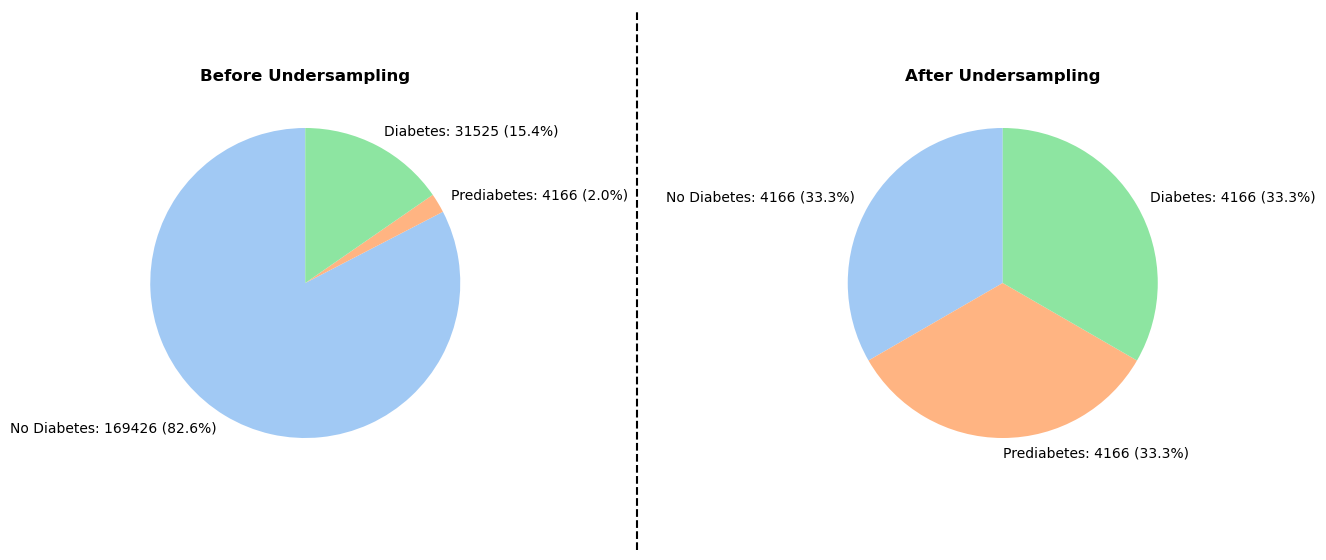

In [3]:
print("Before Undersampling:", Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("After Undersampling:", Counter(y_train_res))
print("X_train_res", X_train_res.shape)
print("y_train_res", y_train_res.shape)


# -----------------------------
# Visualisation for Undersampling with gap and separator line
# -----------------------------
def plot_undersampling_distribution(y_before, y_after, labels_dict):
    """
    Plots the class distribution before and after undersampling as pie charts with a gap and a vertical line between them.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,6))  # wider figure

    # Before undersampling
    counts_before = Counter(y_before)
    sizes_before = [counts_before[k] for k in sorted(counts_before.keys())]
    labels_before = [f"{labels_dict[k]}: {counts_before[k]} ({counts_before[k]/sum(sizes_before)*100:.1f}%)" 
                     for k in sorted(counts_before.keys())]
    
    axes[0].pie(sizes_before, labels=labels_before, autopct='', startangle=90, colors=sns.color_palette("pastel"))
    axes[0].set_title("Before Undersampling", fontweight='bold')

    # After undersampling
    counts_after = Counter(y_after)
    sizes_after = [counts_after[k] for k in sorted(counts_after.keys())]
    labels_after = [f"{labels_dict[k]}: {counts_after[k]} ({counts_after[k]/sum(sizes_after)*100:.1f}%)" 
                    for k in sorted(counts_after.keys())]

    axes[1].pie(sizes_after, labels=labels_after, autopct='', startangle=90, colors=sns.color_palette("pastel"))
    axes[1].set_title("After Undersampling", fontweight='bold')

    # Add gap between subplots
    plt.subplots_adjust(wspace=0.8)

    # Draw a vertical line between the two pie charts
    # x-coordinate of line: halfway between axes[0] and axes[1] in figure coordinates
    fig_width = fig.get_size_inches()[0]
    x_line = 0.5  # normalized figure coordinate (0=left, 1=right)
    plt.figlines = plt.gcf().add_artist(plt.Line2D([x_line, x_line], [0.05, 0.95], color='black', linewidth=1.5, linestyle='--'))

    plt.show()


# Call the function
plot_undersampling_distribution(y_train, y_train_res, label_dict)


<span style="font-family: serif;font-size: 28px;">Feature Scaling</span>

In [ ]:
scaler = RobustScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

<span style="font-family: serif;font-size: 28px;">Visualisation Function</span>

In [5]:
def plot_confusion(y_true, y_pred, labels, title_prefix="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    # Raw counts
    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title_prefix} - Raw Counts")
    plt.show()
    
    # Normalized
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm,
                annot=True,
                fmt='.2f',
                cmap='Greens',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title_prefix} - Normalized")
    plt.show()


<span style="font-family: serif;font-size: 28px;">Logistic Regression</span>

<span style="font-family: serif;font-size: 20px;">Implementation</span>

In [6]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

<span style="font-family: serif;font-size: 20px;">Classification Report</span>

In [7]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.6284937036549515
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.64      0.76     18825
         1.0       0.03      0.31      0.06       463
         2.0       0.36      0.59      0.45      3503

    accuracy                           0.63     22791
   macro avg       0.45      0.51      0.42     22791
weighted avg       0.83      0.63      0.70     22791



<span style="font-family: serif;font-size: 20px;">Visualisations</span>

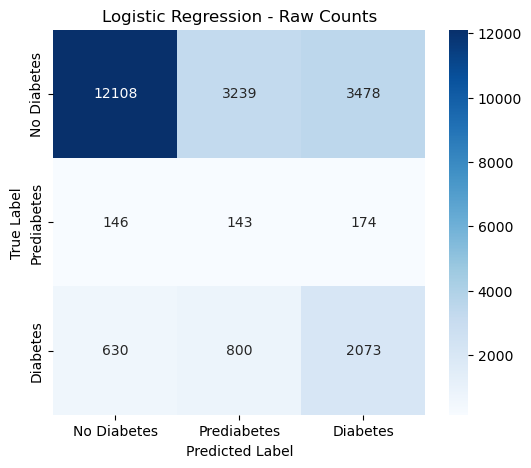

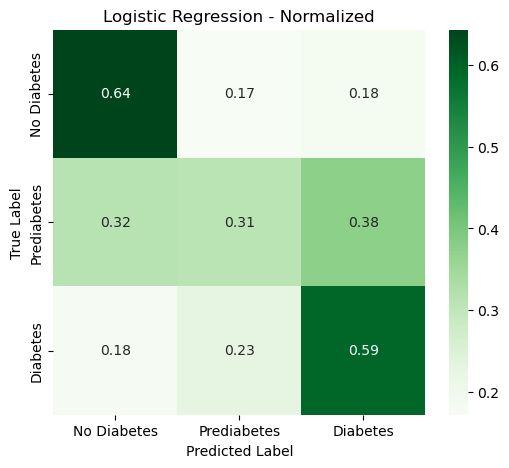

In [8]:
plot_confusion(y_test, y_pred_lr, labels_for_plot, "Logistic Regression")

<span style="font-family: serif;font-size: 28px;">Naive Bayes</span>

<span style="font-family: serif;font-size: 20px;">Implementation</span>

In [9]:
nb_model = GaussianNB()
nb_model.fit(X_train_res, y_train_res)
y_pred_nb = nb_model.predict(X_test)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


<span style="font-family: serif;font-size: 20px;">Classification Report</span>

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Accuracy: 0.6415251634417094
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.65      0.76     18825
         1.0       0.03      0.14      0.05       463
         2.0       0.32      0.68      0.43      3503

    accuracy                           0.64     22791
   macro avg       0.42      0.49      0.42     22791
weighted avg       0.81      0.64      0.70     22791



<span style="font-family: serif;font-size: 20px;">Visualisations</span>

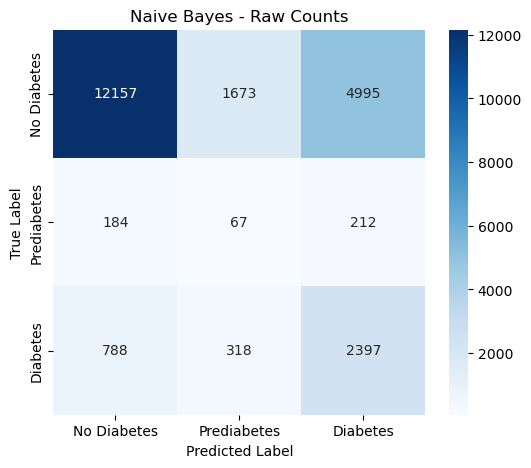

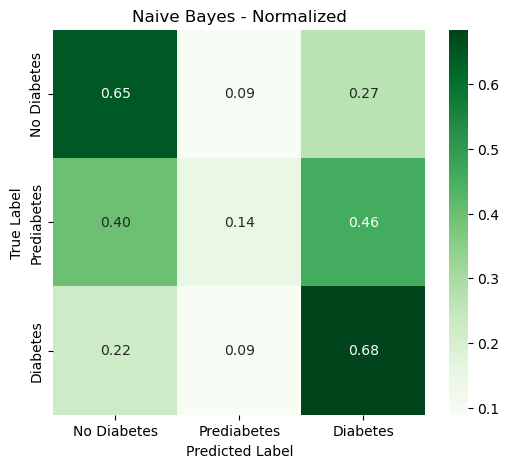

In [11]:
plot_confusion(y_test, y_pred_nb, labels_for_plot, "Naive Bayes")

<span style="font-family: serif;font-size: 28px;">KNN</span>

<span style="font-family: serif;font-size: 20px;">Implementation</span>

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_res, y_train_res)
y_pred_knn = knn_model.predict(X_test)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


<span style="font-family: serif;font-size: 20px;">Classification Report</span>

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.5652231143872581
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.60      0.73     18825
         1.0       0.03      0.43      0.06       463
         2.0       0.31      0.37      0.34      3503

    accuracy                           0.57     22791
   macro avg       0.42      0.47      0.38     22791
weighted avg       0.80      0.57      0.65     22791



<span style="font-family: serif;font-size: 20px;">Visualisations</span>

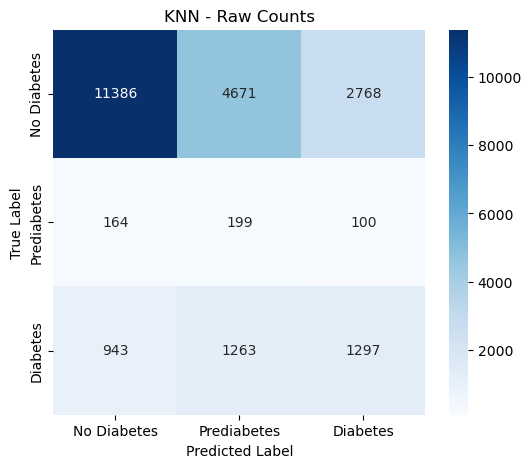

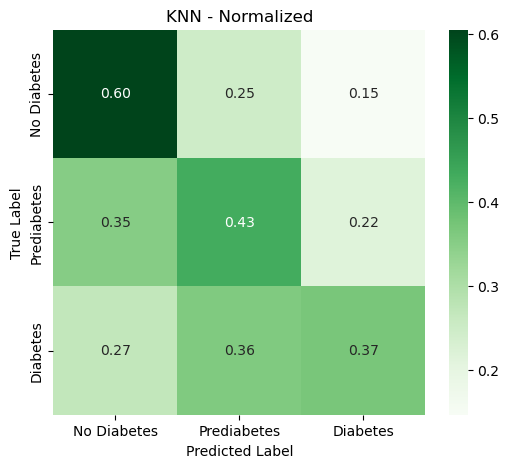

In [14]:
plot_confusion(y_test, y_pred_knn, labels_for_plot, "KNN")

<span style="font-family: serif;font-size: 28px;">Decision Tree</span>

<span style="font-family: serif;font-size: 20px;">Implementation</span>

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_res, y_train_res)
y_pred_dt = dt_model.predict(X_test)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

<span style="font-family: serif;font-size: 20px;">Classification Report</span>

In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy: 0.4586898337062876
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.47      0.62     18825
         1.0       0.02      0.38      0.05       463
         2.0       0.24      0.42      0.31      3503

    accuracy                           0.46     22791
   macro avg       0.39      0.42      0.32     22791
weighted avg       0.78      0.46      0.56     22791



<span style="font-family: serif;font-size: 20px;">Visualisations</span>

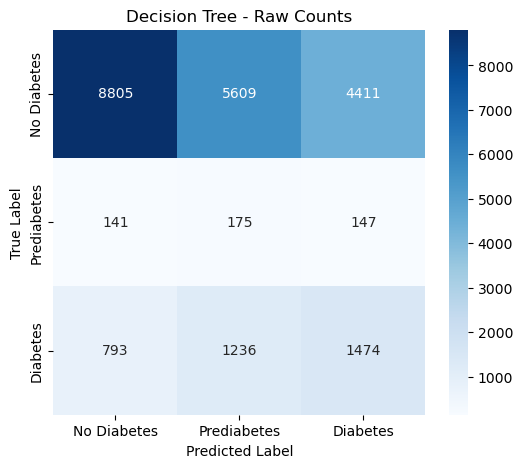

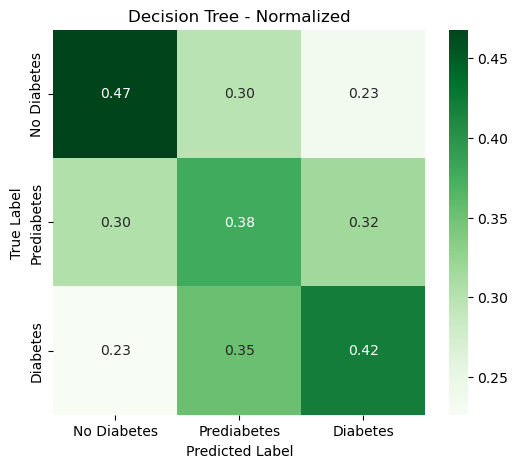

In [17]:
plot_confusion(y_test, y_pred_dt, labels_for_plot, "Decision Tree")

<span style="font-family: serif;font-size: 28px;">Model Results Summary</span>

In [18]:
from sklearn.metrics import classification_report

# Helper function to extract Precision and Recall per class
def get_metrics_per_class(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, output_dict=True)
    # For each label, get precision and recall
    precision_list = []
    recall_list = []
    for l in labels:
        # labels are the names like "No Diabetes", "Diabetes Level 1", "Diabetes Level 2"
        # need to map back to int keys in classification_report
        # classification_report uses string of int as keys
        key = str(label_names[labels.index(l)])
        precision_list.append(report[key]['precision'])
        recall_list.append(report[key]['recall'])
    return precision_list, recall_list

# Collect metrics for each model
models = ["Logistic Regression", "Naive Bayes", "KNN", "Decision Tree"]
y_preds = [y_pred_lr, y_pred_nb, y_pred_knn, y_pred_dt]

# Initialize dictionary for results
results_dict = {
    "Model": [],
    "Accuracy": []
}

# Add Precision and Recall columns for each class
for l in labels_for_plot:
    results_dict[f"Precision ({l})"] = []
    results_dict[f"Recall ({l})"] = []

# Populate metrics
for model_name, y_pred in zip(models, y_preds):
    results_dict["Model"].append(model_name)
    results_dict["Accuracy"].append(accuracy_score(y_test, y_pred))
    
    precision_list, recall_list = get_metrics_per_class(y_test, y_pred, labels_for_plot)
    
    for i, l in enumerate(labels_for_plot):
        results_dict[f"Precision ({l})"].append(round(precision_list[i], 3))
        results_dict[f"Recall ({l})"].append(round(recall_list[i], 3))

# Create DataFrame
results = pd.DataFrame(results_dict)

# Sort by Recall Diabetes and Prediabetes
results = results.sort_values(
    by=["Recall (Prediabetes)", "Recall (Diabetes)"],
    ascending=[False, False]
)


print("=== Models Metrics Summary ===")
display(results)


=== Models Metrics Summary ===


,Model,Accuracy,Precision (No Diabetes),Recall (No Diabetes),Precision (Prediabetes),Recall (Prediabetes),Precision (Diabetes),Recall (Diabetes)
2,KNN,0.565223,0.911,0.605,0.032,0.430,0.311,0.370
3,Decision Tree,0.458690,0.904,0.468,0.025,0.378,0.244,0.421
0,Logistic Regression,0.628494,0.940,0.643,0.034,0.309,0.362,0.592
1,Naive Bayes,0.641525,0.926,0.646,0.033,0.145,0.315,0.684
